In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Data

### consensus_adj_mat

In [2]:
df_adj = pd.read_csv('dataset/consensus_adj_mat.csv')
print(df_adj)

   Unnamed: 0  Akt  Erk  Jnk  Mek  P38  PIP2  PIP3  PKA  PKC  Plcg  Raf
0         Akt    0    0    0    0    0     0     0    0    0     0    0
1         Erk    0    0    0    0    0     0     0    0    0     0    0
2         Jnk    0    0    0    0    0     0     0    0    0     0    0
3         Mek    0    1    0    0    0     0     0    0    0     0    0
4         P38    0    0    0    0    0     0     0    0    0     0    0
5        PIP2    0    0    0    0    0     0     0    0    1     0    0
6        PIP3    1    0    0    0    0     1     0    0    0     1    0
7         PKA    1    1    1    1    1     0     0    0    0     0    1
8         PKC    0    0    1    1    1     0     0    0    0     0    1
9        Plcg    0    0    0    0    0     1     0    0    1     0    0
10        Raf    0    0    0    1    0     0     0    0    0     0    0


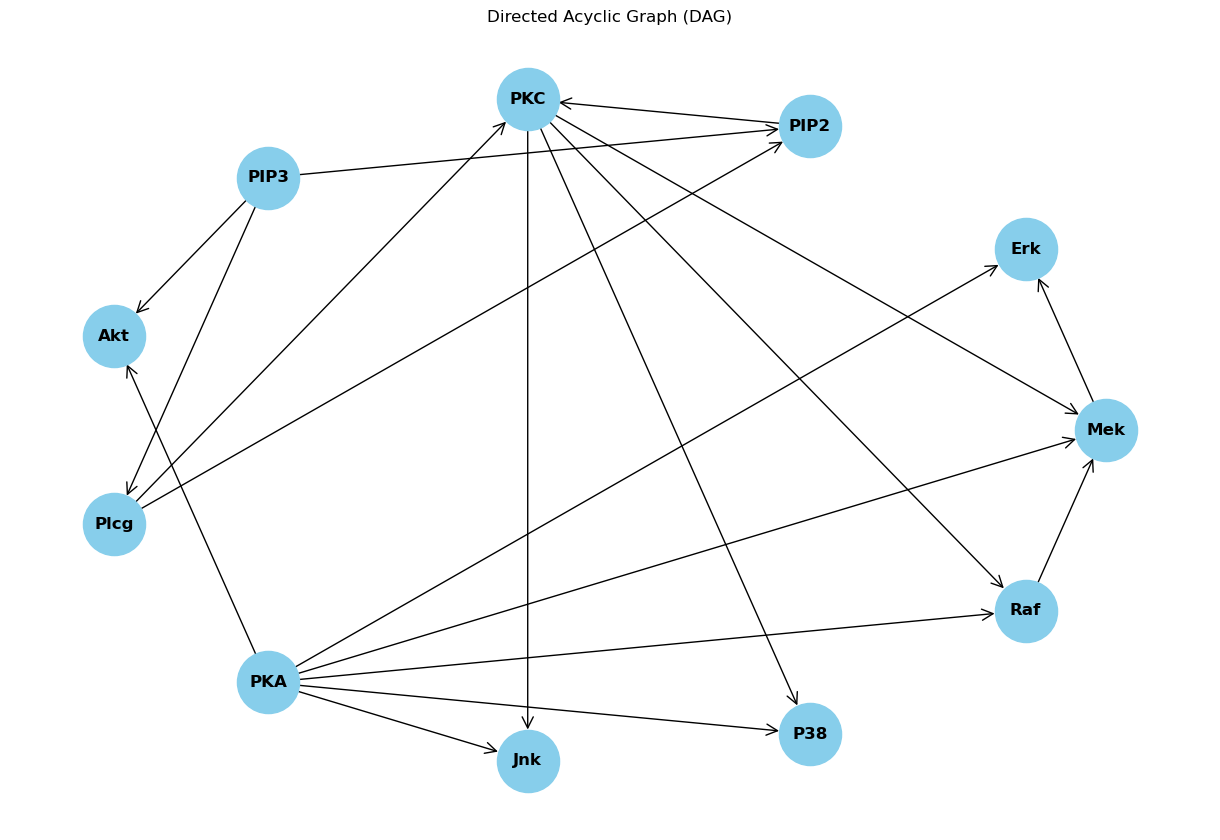

In [3]:
# Initialize a directed graph
G = nx.DiGraph()

# Rename the unnamed column for clarity
df_adj = df_adj.rename(columns={"Unnamed: 0": "Node"})

# Add edges based on the dataframe
for index, row in df_adj.iterrows():
    for col in df_adj.columns[1:]:
        if row[col] == 1:
            G.add_edge(row["Node"], col)

# Use a layout algorithm to position the nodes
pos = nx.circular_layout(G)


# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()


In [4]:
print("Nodes: ", G.nodes)
print("Edges: ", G.edges)

Nodes:  ['Mek', 'Erk', 'PIP2', 'PKC', 'PIP3', 'Akt', 'Plcg', 'PKA', 'Jnk', 'P38', 'Raf']
Edges:  [('Mek', 'Erk'), ('PIP2', 'PKC'), ('PKC', 'Jnk'), ('PKC', 'Mek'), ('PKC', 'P38'), ('PKC', 'Raf'), ('PIP3', 'Akt'), ('PIP3', 'PIP2'), ('PIP3', 'Plcg'), ('Plcg', 'PIP2'), ('Plcg', 'PKC'), ('PKA', 'Akt'), ('PKA', 'Erk'), ('PKA', 'Jnk'), ('PKA', 'Mek'), ('PKA', 'P38'), ('PKA', 'Raf'), ('Raf', 'Mek')]


### sachs_bin

In [5]:
df_raw = pd.read_csv('dataset/sachs_bin.csv')
print(df_raw.head())
print("shape: ", df_raw.shape)

   Akt  Erk  Jnk  Mek  P38  PIP2  PIP3  PKA  PKC
0  0.0  0.0  1.0  0.0  1.0   0.0   1.0  0.0  1.0
1  0.0  0.0  1.0  0.0  0.0   0.0   0.0  0.0  0.0
2  0.0  0.0  0.0  1.0  0.0   0.0   0.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0   0.0   0.0  0.0  0.0
4  1.0  0.0  1.0  0.0  0.0   0.0   0.0  0.0  0.0
shape:  (853, 9)


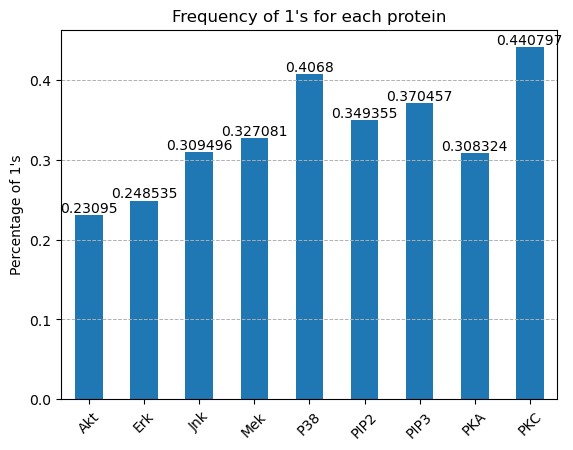

In [61]:
# Calculate the percentage of 1's for each column
percentages = df_raw.mean()  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage

# Plotting
fig, ax = plt.subplots()
percentages.plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel('Percentage of 1\'s')
ax.set_title('Frequency of 1\'s for each protein')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)  # Add gridlines for better readability
plt.show()

# Forward simulation

akt = 1, erk = 2, jnk = 3, mek = 4, p38 = 5, pip2 = 6, pip3 = 7, pka = 8, pkc = 9, plcg = 10, raf = 11 

In [26]:
def simulate_binomial(alpha):
    #pip3, pka
    X7, X8 = np.random.binomial(n=1, p=alpha), np.random.binomial(n=1, p=alpha)
    # print("PIP3: X7 = ", X7, " with probability", alpha)
    # print("PKA: X8 = ", X8, " with probability", alpha)
    
    ### akt <- pip3, pka
    p_X1 = 1 - alpha ** (1+X7+X8) 
    X1 = np.random.binomial(n=1, p=p_X1)
    # print("Akt: X1 = ", X1," with probability", p_X1)

    ### plcg <- pip3
    p_X10 = 1 - alpha ** (1+X7)
    X10 = np.random.binomial(n=1, p=p_X10)
    # print("Plcg: X10 = ", X10," with probability", p_X10)

    ### pip2 <- pip3, plcg
    p_X6 = 1 - alpha ** (1+X7+X10)
    X6 = np.random.binomial(n=1, p=p_X6)
    # print("PIP2: X6 = ", X6," with probability", p_X6)
    
    ### pkc <- plcg, pip2
    p_X9 = 1 - alpha ** (1+X10+X6)
    X9 = np.random.binomial(n=1, p=p_X9)
    # print("PKC: X9 = ", X9," with probability", p_X9)

    ### jnk <- pkc, pka
    p_X3 = 1 - alpha ** (1+X9+X8)
    X3 = np.random.binomial(n=1, p=p_X3)
    # print("Jnk: X3 = ", X3," with probability", p_X3)

    ### p38 <- pkc, pka
    p_X5 = 1 - alpha ** (1+X9+X8)
    X5 = np.random.binomial(n=1, p=p_X5)
    # print("P38: X5 = ", X5," with probability", p_X5)

    ### raf <- pkc, pka
    p_X11 = 1 - alpha ** (1+X9+X8)
    X11 = np.random.binomial(n=1, p=p_X11)
    # print("Raf: X11 = ", X11," with probability", p_X11)

    ### mek <- raf, pka, pkc
    p_X4 = 1 - alpha ** (1+X11+X8+X9)
    X4 = np.random.binomial(n=1, p=p_X4)
    # print("Mek: X4 = ", X4," with probability", p_X4)

    ### erk <- mek, pka
    p_X2 = 1 - alpha ** (1+X4+X8)
    X2 = np.random.binomial(n=1, p=p_X2)
    # print("Erk: X2 = ", X2," with probability", p_X2)

    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]

simulate_binomial(0.5)

[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

In [23]:
def forward(alpha, n):
    lst = []
    for elm in range(0, n):
        lst.append(simulate_binomial(alpha))
    df=pd.DataFrame(lst,columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11'])
    return(df)

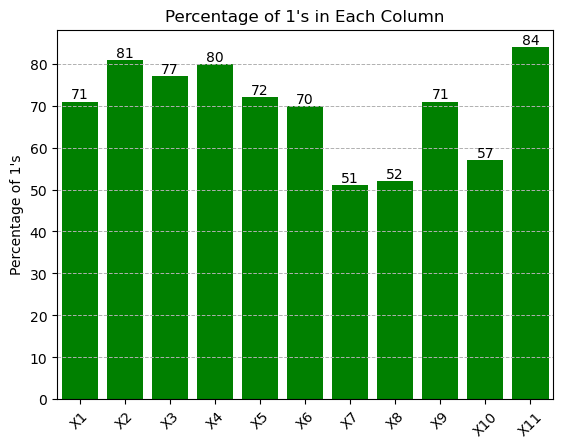

In [56]:
# Calculate the percentage of 1's for each column
percentages = forward(0.5, 100).mean() * 100  # mean() calculates the proportion of 1s, multiplying by 100 gives the percentage

# Plotting
fig, ax = plt.subplots()
percentages.plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_ylabel('Percentage of 1\'s')
ax.set_title('Percentage of 1\'s in Each Column')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.grid(axis='y', linestyle='--', linewidth=0.7)  # Add gridlines for better readability
#make plot red
plt.bar(percentages.index, percentages, color='green')

plt.show()